<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/NGC_2264/NGC_2264_version_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Packages and download the csv files

#### Importing packages

In [ ]:
# import packages
import pandas as pd
import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for downloading file
from google.colab import files

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install astroquery

     |████████████████████████████████| 6.5MB 3.5MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 2.6MB 47.5MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=c5bd0e9b8859ae2028a046ae4eb888308d283f4a59e3957e636431461a7f6131
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery


In [ ]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


#### Finding GAIA Data

In [ ]:
## making a GAIA cone_search of 30m radius around NGC2264 center

coordinate = coord.SkyCoord.from_name('NGC2264')
print(coordinate)
radius = u.Quantity(0.8, u.deg)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (100.24166667, 9.895)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [ ]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
0,1635721458409799680,Gaia DR2 3326740861276259712,3326740861276259712,1365441235,2015.5,100.243956,0.279077,9.895051,0.338835,-6.363450,0.453980,-14.017026,-1.800098,0.465340,-6.549197,0.395891,-0.027930,-0.381382,-0.265434,0.435133,-0.707267,0.011102,-0.232205,0.354407,-0.090069,-0.305690,107,107,89,18,21.666466,791.063416,0.768447,7.312817e+01,31,False,1.647182,1.958272,0.091477,-0.300088,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.936733,2.197765,100.365773,-13.176377,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.002250
1,1635721458409799680,Gaia DR2 3326740865570982400,3326740865570982400,911205744,2015.5,100.244416,0.523372,9.895739,0.496103,-0.784504,0.624335,-1.256544,-4.384980,0.991793,-6.574989,0.845571,-0.094483,0.201876,-0.028343,0.144926,-0.282828,0.020784,-0.170535,0.376963,0.019215,-0.000028,170,170,159,11,202.745163,101416.773438,2.757565,2.478628e+03,31,False,0.116784,1.690997,0.164906,-0.065167,...,8.760636e+07,398875.820038,219.633179,4.905581,1.017091,0,-0.378240,0.017767,-0.396007,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.936327,2.198482,100.366186,-13.175658,110101,9705.000000,8418.333008,9985.000000,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.002803
2,1635721458409799680,Gaia DR2 3326740865568919040,3326740865568919040,1396358324,2015.5,100.244941,0.598125,9.898119,0.510224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.211070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,0,44,0,13.614263,322.398376,1.820949,3.011286e+01,3,False,0.264112,1.641529,0.160584,-0.200346,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.934444,2.200029,100.366538,-13.173247,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.004486
3,1635721458409799680,Gaia DR2 3326741067438961664,3326741067438961664,1025584172,2015.5,100.241715,0.049001,9.899756,0.052610,1.286984,0.064376,19.991558,-1.463974,0.099293,-3.628493,0.089287,-0.083009,0.061895,-0.203724,0.138530,-0.572859,-0.000420,-0.285847,0.180690,0.150106,-0.020889,143,0,143,0,11.385525,425.318573,0.304088,1.281109e+01,31,False,8.402239,1.500643,0.012230,-0.026078,...,3.227904e+04,1155.900454,27.925447,13.489618,1.411567,0,1.374199,0.503114,0.871085,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.931534,2.197949,100.363161,-13.171844,102001,4720.549805,4425.000000,5016.100098,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.466251,1.298557,1.668657,0.961793,0.859278,1.064309,https://gea.esac.esa.int/data-server/datalink/...,,0.004763
4,1635721458409799680,Gaia DR2 3326740968649524480,3

##### Applying Filter:

In [ ]:
all_stars['pmra_over_error'] = abs(all_stars['pmra']/all_stars['pmra_error'])
all_stars['pmdec_over_error'] = abs(all_stars['pmdec']/all_stars['pmdec_error'])

In [ ]:
all_stars_filtered = all_stars[all_stars['parallax_over_error'] > 3]

In [ ]:
all_stars_filtered = all_stars_filtered[(all_stars_filtered['pmdec_over_error'] > 3) & (all_stars_filtered['pmra_over_error'] > 3)]

In [ ]:
all_stars_filtered.shape

(8579, 99)

##### Visualizing GAIA data

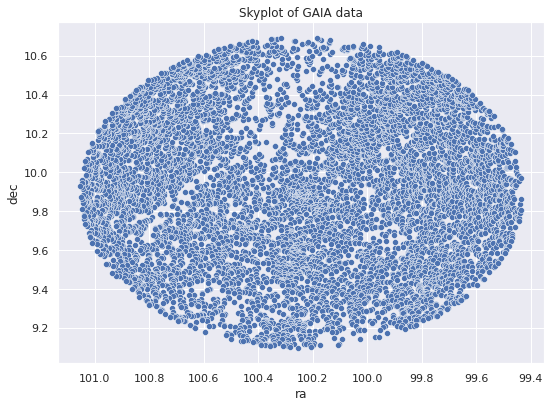

In [ ]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', 
                          data = all_stars_filtered)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

#### Finding Cantat Data

In [ ]:
#### Finding Cantat catalogue

catalog_list = Vizier.find_catalogs('Cantat')
{k:v.description for k,v in catalog_list.items()}

{'I/349': 'StarHorse, Gaia DR2 photo-astrometric distances (Anders+, 2019)',
 'J/A+A/561/A94': 'Velocities and photometry in Trumpler 20 (Donati+, 2014)',
 'J/A+A/564/A133': 'Gaia FGK benchmark stars: metallicity (Jofre+, 2014)',
 'J/A+A/569/A17': 'Gaia-ESO Survey: NGC6705 (Cantat-Gaudin+, 2014)',
 'J/A+A/582/A81': 'Gaia FGK benchmark stars: abundances (Jofre+, 2015)',
 'J/A+A/588/A120': 'Equivalent widths in 10 open clusters (Cantat-Gaudin+, 2016)',
 'J/A+A/591/A37': 'Gaia-ESO Survey. Parameters for cluster members (Jacobson+, 2016)',
 'J/A+A/597/A10': 'South Ecliptic Pole stars radial velocities (Fremat+, 2017)',
 'J/A+A/598/A68': 'Gaia-ESO Survey. Trumpler 23 (Overbeek+, 2017)',
 'J/A+A/601/A19': 'Gaia DR1 open cluster members (Gaia Collaboration+, 2017)',
 'J/A+A/603/A2': 'Gaia-ESO Survey abundances radial distribution (Magrini+, 2017)',
 'J/A+A/605/A79': 'TGAS Cepheids and RR Lyrae stars (Gaia Collaboration+, 2017)',
 'J/A+A/615/A49': 'TGAS stars membership in 128 open clusters (C

In [ ]:
## cheking the tables in the GAIA DR2 paper

Vizier.ROW_LIMIT = -1
#catalogs = Vizier.get_catalogs(catalog_list['J/A+A/633/A99'])
#catalogs

In [ ]:
## saving only NGC 2264 data from Cantat GAIA DR2 paper

cantat_2264 = Vizier(catalog = 'J/A+A/633/A99/members', row_limit = -1).query_constraints(Cluster="NGC_2264")
cantat_2264 = cantat_2264[0].to_pandas()
cantat_2264

,RA_ICRS,DE_ICRS,Source,Plx,pmRA,pmDE,RV,Gmag,BP-RP,Proba,Cluster,_RA.icrs,_DE.icrs
0,100.288919,9.935567,3326741415326788480,1.3254,-1.851,-4.220,NaN,16.416100,3.1947,1.0,NGC_2264,100.288927,9.935585
1,100.268700,9.870169,3326739933563070720,1.3051,-0.975,-4.047,NaN,17.872499,2.0718,0.7,NGC_2264,100.268704,9.870186
2,100.321455,9.894364,3326740418894376704,1.2577,-1.297,-3.914,NaN,17.051701,2.4179,0.8,NGC_2264,100.321461,9.894381
3,100.293254,9.883825,3326740006577519360,1.1663,-1.773,-4.213,NaN,9.904700,-0.0007,0.8,NGC_2264,100.293262,9.883843
4,100.229922,9.847141,3326716397142282240,1.2713,-1.759,-2.658,NaN,15.305900,1.7208,0.1,NGC_2264,100.229930,9.847153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,100.139414,9.950729,3326929839837216640,1.1883,-1.923,-4.212,NaN,17.801300,2.6959,0.7,NGC_2264,100.139422,9.950747
182,100.240944,9.941617,3326929225657356288,1.3572,-1.452,-3.866,NaN,13.435300,1.1690,1.0,NGC_2264,100.240950,9.941634
183,100.190391,9.995125,3326930393888460288,1.5371,-1.218,-4.083,NaN,17.504801,2.3604,0.7,NGC_2264,100.190396,9.995143
184,100.223620,9.966662,3326929500535262464,1.4464,-1.454,-3.649,NaN,16.329500,2.0670,1.0,NGC_2264,100.223627,9.966677


In [ ]:
# renaming the cantat table to match it with gaia_data
cantat_2264 = cantat_2264.rename(columns={'Source':'source_id',
                                          'Proba':'PMemb'})


In [ ]:
# taking the subset of only source_id and PMemb
cantat_2264 = cantat_2264.loc[:,['source_id', 'PMemb']]


In [ ]:
# join the two table on source_id
cantat_2264 = all_stars_filtered.join(cantat_2264.set_index('source_id'), on='source_id')

In [ ]:
# dropping the rows, where we don't have PMemb 
# (i.e. the source id was not in the cantat table)
cantat_2264 = cantat_2264.dropna(subset=['PMemb'])
cantat_2264

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb
3,1635721458409799680,Gaia DR2 3326741067438961664,3326741067438961664,1025584172,2015.5,100.241715,0.049001,9.899756,0.052610,1.286984,0.064376,19.991558,-1.463974,0.099293,-3.628493,0.089287,-0.083009,0.061895,-0.203724,0.138530,-0.572859,-0.000420,-0.285847,0.180690,0.150106,-0.020889,143,0,143,0,11.385525,425.318573,0.304088,12.811090,31,False,8.402239,1.500643,0.012230,-0.026078,...,13.489618,1.411567,0,1.374199,0.503114,0.871085,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.931534,2.197949,100.363161,-13.171844,102001,4720.549805,4425.000000,5016.100098,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.466251,1.298557,1.668657,0.961793,0.859278,1.064309,https://gea.esac.esa.int/data-server/datalink/...,,0.004763,14.744018,40.638442,1.0
5,1635721458409799680,Gaia DR2 3326740865570981632,3326740865570981632,1521413039,2015.5,100.245557,0.038982,9.900196,0.038836,1.362735,0.045918,29.677427,-1.137068,0.079773,-3.588939,0.074279,0.012196,-0.038531,-0.197566,0.162975,-0.433419,0.086858,-0.276304,0.140726,0.135813,-0.020499,159,159,156,3,12.263560,478.664429,0.067057,1.356665,31,True,110.686615,1.704489,0.010583,-0.030650,...,10.502198,1.172351,0,0.343633,0.126979,0.216654,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.932872,2.201518,100.367005,-13.171131,100001,7839.666504,7700.000000,8181.666504,0.600,0.1560,1.0341,0.3433,0.0770,0.5181,200111,2.492503,2.288481,2.583743,21.142500,20.141113,22.143887,https://gea.esac.esa.int/data-server/datalink/...,,0.006458,14.253728,48.316705,0.9
8,1635721458409799680,Gaia DR2 3326740964359745920,3326740964359745920,238254446,2015.5,100.232937,0.043918,9.898147,0.044957,1.248683,0.052859,23.623098,-1.432188,0.086068,-3.728367,0.076559,-0.064223,-0.099656,-0.225813,0.266703,-0.460557,0.141547,-0.359061,0.218600,0.111144,-0.075713,164,0,163,1,1.117678,177.989960,0.075689,0.373744,31,False,9.581892,1.381862,0.011180,-0.008528,...,14.794998,1.426720,0,1.878511,0.855293,1.023218,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.929017,2.189521,100.354423,-13.174077,100001,4027.333252,3858.000000,4257.020020,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.247874,1.116849,1.359820,0.369068,0.334995,0.403141,https://gea.esac.esa.int/data-server/datalink/...,,0.009165,16.640103,48.699532,1.0
9,1635721458409799680,Gaia DR2 3326740861280539136,3326740861280539136,667918271,2015.5,100.248924,0.032822,9.901716,0.032414,1.332304,0.040609,32.807835,-2.016628,0.074140,-3.112353,0.080114,-0.017695,-0.143776,-0.059924,0.023423,-0.409806,0.074095,-0.174889,-0.038104,0.321486,-0.359434,143,0,143,0,0.018795,137.645889,0.000000,0.000000,31,False,20.898325,1.428460,0.008630,-0.085661,...,14.142661,1.401709,0,1.642935,0.698737,0.944198,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.933034,2.205162,100.370288,-13.169374,100001,4315.0

In [ ]:
# saving both cantat and Gaia files as csv
# if you want to save, comment out the next two lines

cantat_2264.to_csv('NGC_2264_cantat.csv')
# all_stars.to_csv('NGC_2264_Gaia_30m.csv')

In [ ]:
cantat_2264.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb
count,1.850000e+02,1.850000e+02,1.850000e+02,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,1.800000e+02,180.000000,180.000000,180.000000,180.000000,185.000000,180.000000,180.000000,180.000000,3.000000,3.000000,185.000000,3.000000,3.000000,3.0,185.000000,185.000000,185.000000,185.000000,144.000000,144.000000,144.000000,144.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,185.000000,185.000000,185.000000,185.000000
mean,1.635721e+18,3.326784e+18,8.285892e+08,2015.5,100.214039,0.072382,9.878222,0.071669,1.351449,0.081936,21.650196,-1.719405,0.141126,-3.745357,0.125302,-0.127327,-0.013217,-0.228196,0.287496,-0.384634,0.185720,-0.357903,0.201840,0.088960,-0.103946,152.875676,17.027027,151.940541,0.935135,4.139026,298.636963,0.213379,4.722191,31.0,28.285501,1.399563,0.018449,-0.035289,17.416216,10.637838,...,1.240357e+05,345.509270,187.808090,14.515929,1.472430,0.129730,1.861798,0.861647,1.000150,17.663946,6.709235,0.102703,5833.333496,3.833333,0.0,202.938244,2.163860,100.336830,-13.195288,100556.638889,4531.785645,4245.857422,4903.776855,1.747458,1.442371,1.986919,0.877488,0.713944,1.003771,200111.0,1.408720,1.217725,1.548704,1.195102,1.119066,1.271138,0.081564,15.793914,38.804363,0.865946
std,0.000000e+00,8.908293e+13,5.079494e+08,0.0,0.060929,0.039388,0.063977,0.039081,0.098816,0.044591,10.962818,0.439083,0.075826,0.300983,0.066869,0.167233,0.138062,0.134414,0.129976,0.127064,0.127836,0.117483,0.115337,0.110659,0.180214,17.322413,47.526587,17.354104,1.484012,8.059679,625.573181,0.227932,18.497970,0.0,72.251717,0.133858,0.009985,0.078989,1.951799,0.678614,...,4.770235e+05,941.807797,185.221085,1.783798,0.223623,0.409709,0.685158,0.381381,0.348479,6.235787,4.756371,0.811094,288.675140,0.577350,0.0,0.058022,0.065835,0.060710,0.064826,898.928007,1413.615845,1237.766357,1462.936646,0.987902,0.909715,1.042373,0.494933,0.455351,0.527763,0.0,0.618332,0.618088,0.611171,3.740212,3.529193,3.951503,0.045111,8.759246,19.136053,0.202906
min,1.635721e+18,3.326712e+18,5.929410e+05,2015.5,100.057096,0.023724,9.751314,0.022577,1.092609,0.026016,6.027352,-3.389699,0.045983,-5.199818,0.041781,-0.960296,-0.685270,-0.885211,-0.377267,-0.702543,-0.207624,-0.933394,-0.694126,-0.667703,-0.896725,105.000000,0.000000,101.000000,0.000000,-6.4

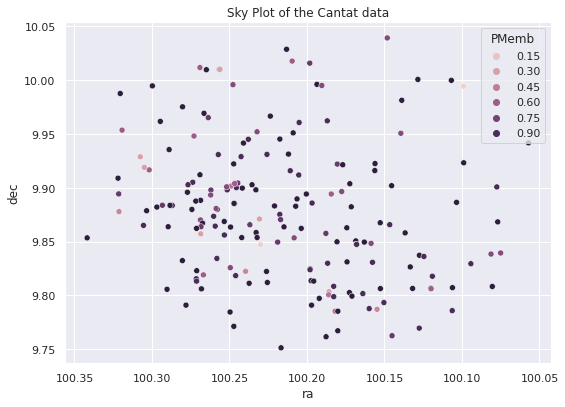

In [ ]:
## plotting the skyplot 

skyplot = sns.scatterplot(x = cantat_2264['ra'], y = cantat_2264['dec'], 
                          hue = cantat_2264['PMemb'])
skyplot.invert_xaxis()
plt.title('Sky Plot of the Cantat data')
plt.show()

### Creating, Examining and Processing the Training Data


#### Training Data

In [ ]:
# import member dataset
member = cantat_2264.copy()

In [ ]:
### adding their distance from the center of the clusters

## NGC 2264
center = coord.SkyCoord.from_name('NGC2264')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((member['ra'] - center_ra)*np.cos(np.radians(member['dec'])))**2 + (member['dec'] - center_dec)**2 )
member['dist_2264_center'] = distance

In [ ]:
# maximum distance of stars in Cantat Data
max(member.dist_2264_center)

0.1877294773088183

In [ ]:
member['member'] = np.full(len(member), 1)
member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
3,1635721458409799680,Gaia DR2 3326741067438961664,3326741067438961664,1025584172,2015.5,100.241715,0.049001,9.899756,0.052610,1.286984,0.064376,19.991558,-1.463974,0.099293,-3.628493,0.089287,-0.083009,0.061895,-0.203724,0.138530,-0.572859,-0.000420,-0.285847,0.180690,0.150106,-0.020889,143,0,143,0,11.385525,425.318573,0.304088,12.811090,31,False,8.402239,1.500643,0.012230,-0.026078,...,0,1.374199,0.503114,0.871085,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.931534,2.197949,100.363161,-13.171844,102001,4720.549805,4425.000000,5016.100098,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.466251,1.298557,1.668657,0.961793,0.859278,1.064309,https://gea.esac.esa.int/data-server/datalink/...,,0.004763,14.744018,40.638442,1.0,0.004757,1
5,1635721458409799680,Gaia DR2 3326740865570981632,3326740865570981632,1521413039,2015.5,100.245557,0.038982,9.900196,0.038836,1.362735,0.045918,29.677427,-1.137068,0.079773,-3.588939,0.074279,0.012196,-0.038531,-0.197566,0.162975,-0.433419,0.086858,-0.276304,0.140726,0.135813,-0.020499,159,159,156,3,12.263560,478.664429,0.067057,1.356665,31,True,110.686615,1.704489,0.010583,-0.030650,...,0,0.343633,0.126979,0.216654,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.932872,2.201518,100.367005,-13.171131,100001,7839.666504,7700.000000,8181.666504,0.6,0.156,1.0341,0.3433,0.077,0.5181,200111,2.492503,2.288481,2.583743,21.142500,20.141113,22.143887,https://gea.esac.esa.int/data-server/datalink/...,,0.006458,14.253728,48.316705,0.9,0.006457,1
8,1635721458409799680,Gaia DR2 3326740964359745920,3326740964359745920,238254446,2015.5,100.232937,0.043918,9.898147,0.044957,1.248683,0.052859,23.623098,-1.432188,0.086068,-3.728367,0.076559,-0.064223,-0.099656,-0.225813,0.266703,-0.460557,0.141547,-0.359061,0.218600,0.111144,-0.075713,164,0,163,1,1.117678,177.989960,0.075689,0.373744,31,False,9.581892,1.381862,0.011180,-0.008528,...,0,1.878511,0.855293,1.023218,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.929017,2.189521,100.354423,-13.174077,100001,4027.333252,3858.000000,4257.020020,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.247874,1.116849,1.359820,0.369068,0.334995,0.403141,https://gea.esac.esa.int/data-server/datalink/...,,0.009165,16.640103,48.699532,1.0,0.009157,1
9,1635721458409799680,Gaia DR2 3326740861280539136,3326740861280539136,667918271,2015.5,100.248924,0.032822,9.901716,0.032414,1.332304,0.040609,32.807835,-2.016628,0.074140,-3.112353,0.080114,-0.017695,-0.143776,-0.059924,0.023423,-0.409806,0.074095,-0.174889,-0.038104,0.321486,-0.359434,143,0,143,0,0.018795,137.645889,0.000000,0.000000,31,False,20.898325,1.428460,0.008630,-0.085661,...,0,1.642935,0.698737,0.944198,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.933034,2.205162,100.370288,-13.169374,100001,4315.000000,4194.449707,4420.750000,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.31

In [ ]:
### adding their distance from the center of the clusters

## NGC 2264
center = coord.SkyCoord.from_name('NGC2264')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((all_stars_filtered['ra'] - center_ra)*np.cos(np.radians(all_stars_filtered['dec'])))**2 + (all_stars_filtered['dec'] - center_dec)**2 )
all_stars_filtered['dist_2264_center'] = distance

In [ ]:
non_member = all_stars_filtered[all_stars_filtered['dist_2264_center'] >= 0.7].sample(len(member), random_state = 42)

In [ ]:
non_member['member'] = np.full(len(non_member), 0)
non_member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,dist_2264_center,member
46342,1635721458409799680,Gaia DR2 3326655756499285760,3326655756499285760,1652804856,2015.5,100.888352,0.039105,9.555642,0.036591,0.473807,0.048679,9.733236,-0.292594,0.074390,-2.284371,0.073854,-0.455019,0.511800,0.209071,-0.030837,-0.513548,-0.297968,0.073725,0.331547,0.151635,-0.436137,121,0,121,0,-0.101159,113.806503,0.000000,0.000000,31,False,31.991135,1.446853,0.007133,-0.216038,...,1.295202,0,1.593225,0.748718,0.844507,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,203.528875,2.608349,101.042780,-13.467222,100001,4319.50000,4121.427734,4505.296875,NaN,NaN,NaN,NaN,NaN,NaN,200111,4.580067,4.210095,5.030873,6.579187,5.087944,8.070431,https://gea.esac.esa.int/data-server/datalink/...,,0.722093,3.933244,30.930794,0.722386,0
51993,1635721458409799680,Gaia DR2 3326971385056202112,3326971385056202112,1226585802,2015.5,99.514480,0.152461,10.142287,0.140692,3.269342,0.167015,19.575089,-14.453494,0.287699,-8.125552,0.282536,0.078840,0.127147,-0.074912,0.359488,-0.146615,0.270197,-0.132858,0.255037,0.229782,-0.073830,103,0,102,1,5.136918,186.549820,0.582741,4.149275,31,False,1.108422,1.295025,0.043860,0.074998,...,1.528481,0,2.356594,1.164192,1.192402,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.388018,1.672015,99.612320,-12.980081,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.757601,50.238201,28.759381,0.757334,0
53730,1635721458409799680,Gaia DR2 3326675822586388352,3326675822586388352,714416233,2015.5,100.992261,0.031424,9.687031,0.028104,0.233333,0.035303,6.609448,-0.427762,0.055967,-0.205775,0.047915,-0.291165,0.315786,-0.146249,0.277915,-0.288298,0.136156,-0.382968,0.316544,0.142670,-0.171188,142,0,142,0,-0.729162,124.654167,0.000000,0.000000,31,False,34.854301,1.633137,0.006677,-0.121230,...,1.210490,0,0.690667,0.259973,0.430695,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,203.458418,2.759363,101.137294,-13.328279,100001,6738.00000,6054.000000,7252.583496,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.768334,7.643047,4.294600,0.768564,0
47308,1635721458409799680,Gaia DR2 3326602842502329856,3326602842502329856,65322423,2015.5,99.694110,0.098333,9.406151,0.124274,3.869457,0.148408,26.073038,29.198314,0.186964,-36.391539,0.174856,-0.412781,0.269183,-0.001486,0.250518,-0.700707,-0.065174,-0.258760,0.301273,0.183221,-0.307373,114,0,114,0,4.899990,197.541901,0.343394,2.822150,31,False,2.629717,1.340720,0.024366,-0.165472,...,1.419880,0,2.367661,1.253471,1.114189,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,203.123741,1.492131,99.845433,-13.702428,100001,3770.35498,3390.250000,4302.310059,0.1905,0.0035,0.463,0.1213,0.0017,0.2371,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


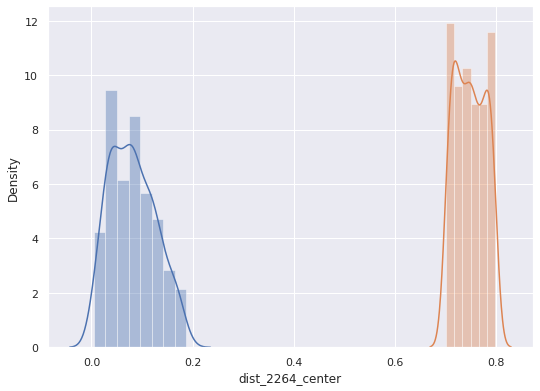

In [ ]:
sns.distplot(member['dist_2264_center'])
sns.distplot(non_member['dist_2264_center'])
plt.show()

In [ ]:
training_data = pd.concat([member, non_member])

In [ ]:
# Examining the descriptive statistics of each column
training_data.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
count,3.700000e+02,3.700000e+02,3.700000e+02,370.0,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.0,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,364.000000,364.000000,364.000000,370.000000,364.000000,364.000000,364.000000,6.000000,6.000000,370.000000,6.000000,6.000000,6.0,370.000000,370.000000,370.000000,370.000000,285.000000,285.000000,285.000000,285.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,213.0,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,370.000000,370.000000,370.000000,185.000000,370.000000,370.000000
mean,1.635721e+18,3.331983e+18,8.218599e+08,2015.5,100.292674,0.084451,9.923165,0.083805,1.145213,0.092417,17.113571,-0.878657,0.161027,-3.773610,0.143564,-0.187334,0.016131,-0.229033,0.300258,-0.360294,0.182173,-0.363754,0.235928,0.077611,-0.143626,142.448649,11.494595,141.616216,0.832432,2.470246,221.690292,0.169598,2.871248,31.0,27.379450,1.435166,0.020157,-0.053526,16.256757,10.364865,...,280.132019,14.836404,1.402921,0.091892,1.704096,0.785723,0.918372,11.345014,4.278453,0.083784,5666.666504,4.000000,0.0,202.933395,2.253325,100.412700,-13.144308,100302.824561,4624.665039,4390.260742,4941.019531,1.317253,1.062021,1.570704,0.656377,0.521524,0.790837,200111.0,1.853748,1.665437,2.000339,3.195262,2.710744,3.679779,0.415417,18.352815,39.866089,0.865946,0.415394,0.500000
std,0.000000e+00,9.930764e+15,5.097146e+08,0.0,0.396848,0.078863,0.360721,0.078849,0.792939,0.072627,13.724460,3.376608,0.141755,3.958280,0.130906,0.198859,0.183877,0.178191,0.153841,0.180717,0.179335,0.147201,0.126620,0.139252,0.194242,21.359963,39.312744,21.275805,1.291635,6.283752,450.771881,0.239653,13.395382,0.0,67.690567,0.121987,0.015440,0.087368,2.367696,0.757516,...,252.473404,1.668666,0.193874,0.340873,0.616154,0.347800,0.300115,28.431774,4.018604,0.675556,258.198883,0.547723,0.0,0.351811,0.399168,0.398516,0.363723,717.117350,1109.912476,1001.897217,1146.061157,0.863433,0.802358,0.899345,0.432570,0.400018,0.455123,0.0,2.356911,2.207153,2.476042,14.032598,11.273462,16.818041,0.336468,19.698167,35.343833,0.202906,0.336444,0.500677
min,1.635721e+18,3.326524e+18,5.929410e+05,2015.5,99.440308,0.022675,9.110603,0.021199,0.195105,0.023522,3.000654,-17.643262,0.043238,-36.391539,0.037520,-0.960296,-0.690899,-0.894510,-0.377267,-0.818992,-0.474425,-0.933394,-0.694126,-0.667703,-0.896725,82.000000,0.000000,82.000000,0.000000,-6.497139,44.363960,0.00000

In [ ]:
# Choosing the features

feature_columns = ['parallax',
                   'pmra', 'pmdec']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [ ]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')


# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,parallax,pmra,pmdec
count,370.000000,370.000000,370.000000
mean,1.145213,-0.878657,-3.773608
std,0.792939,3.376608,3.958281
min,0.195105,-17.643263,-36.391541
25%,0.644421,-1.865498,-4.044963
50%,1.282717,-1.502002,-3.684880
75%,1.393442,-0.426769,-2.807047
max,11.395401,29.198313,10.774017


In [ ]:
targets.value_counts()

1    185
0    185
Name: member, dtype: int64

#### Visualizing Training Data


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


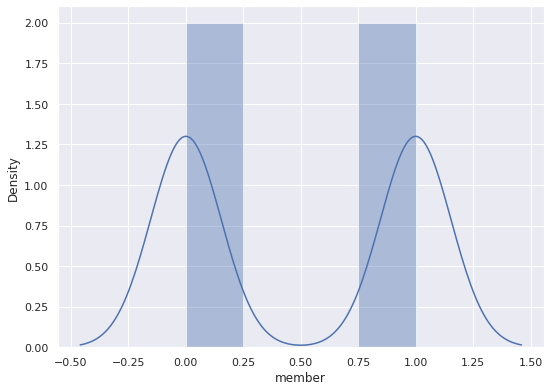

In [ ]:
# histogram of PMemb in the training data
sns.distplot(training_set['member'])
plt.show()

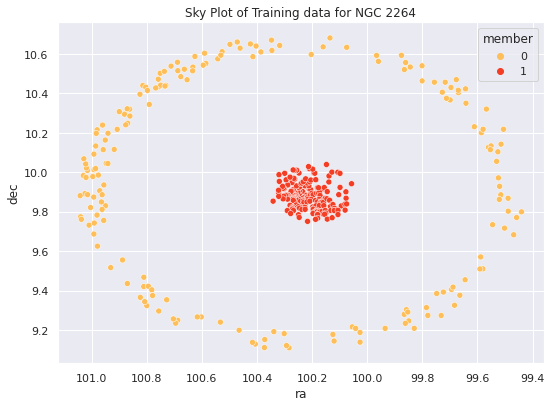

In [ ]:
sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x = 'ra', y='dec', palette='YlOrRd', hue = 'member', data = training_data)
skyplot.invert_xaxis()
plt.title('Sky Plot of Training data for NGC 2264')
plt.show()

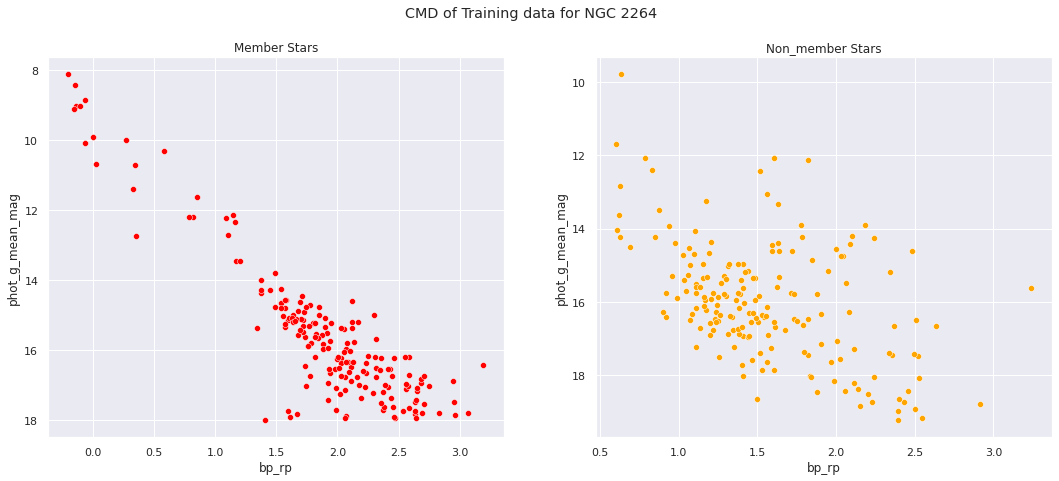

In [ ]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)
#cmd = sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', hue = 'PMemb', data = training_data)
#cmd.invert_yaxis()
#plt.title('')
#plt.show()

# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.suptitle('CMD of Training data for NGC 2264 ')

sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
axes[0].invert_yaxis()

#plt.show()
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
axes[1].invert_yaxis()

plt.show()


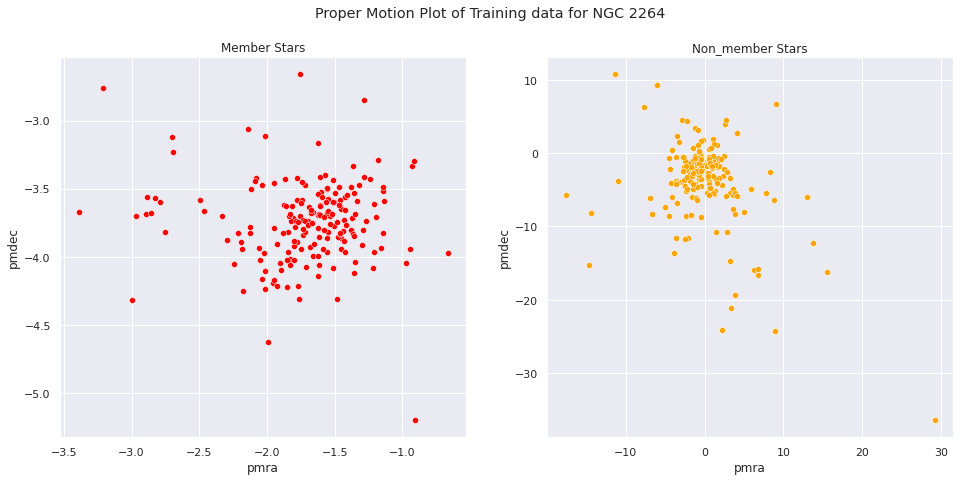

In [ ]:
# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Proper Motion Plot of Training data for NGC 2264 ')

sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
#plt.show()
sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


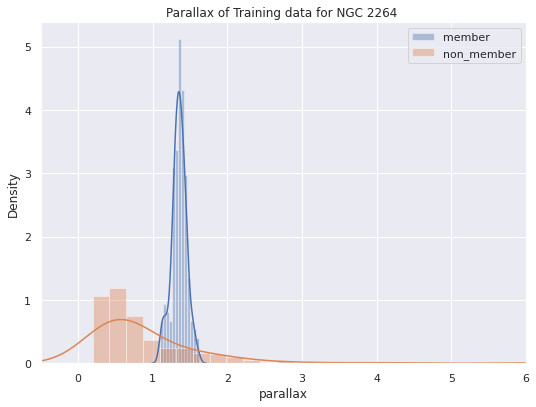

In [ ]:
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.xlim(-0.5,6)
plt.title('Parallax of Training data for NGC 2264 ')
plt.legend()
plt.show()

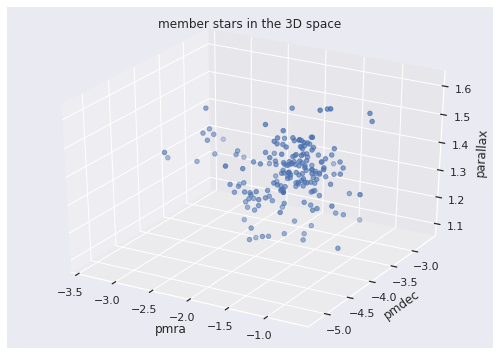

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


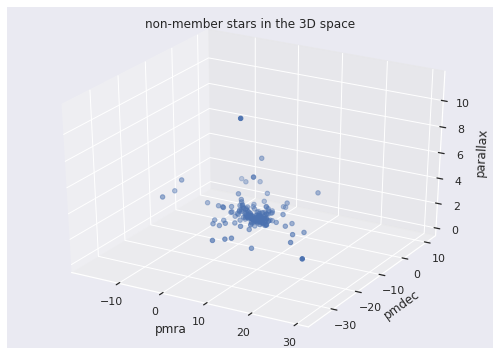

In [ ]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


#### Check Feature Importance using Random Forest

In [ ]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True)
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

parallax    0.408148
pmra        0.305206
pmdec       0.286646
dtype: float64

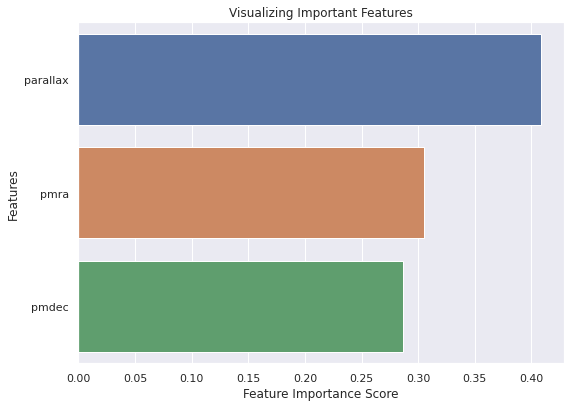

In [ ]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Selection and Accuracy Estimate using Test Data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report

In [ ]:
from sklearn.model_selection import train_test_split
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                                targets, 
                                                                                test_size = 0.3, 
                                                                                random_state=258)

In [ ]:
def evaluate_model(model):
    test_predict = model.predict(test_features)
    train_predict = model.predict(train_features)

    print('Model Accuracy:')
    print("Precision on training data: %.3f" % precision_score(train_targets, train_predict))
    print("Precision on testing data: %.3f" % precision_score(test_targets, test_predict))
    print('Accuracy on test data: %.3f' % accuracy_score(test_targets, test_predict))


    sns.heatmap(confusion_matrix(test_targets, test_predict), cmap= 'Greens', annot = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report: \n", classification_report(test_targets, test_predict))

#### SVC

In [ ]:
from sklearn.svm import SVC

# SVC model
svc_clf = SVC(kernel='rbf', gamma = 'scale', random_state=42)

svc_clf.fit(train_features, train_targets)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Model Accuracy:
Precision on training data: 0.860
Precision on testing data: 0.886
Accuracy on test data: 0.928


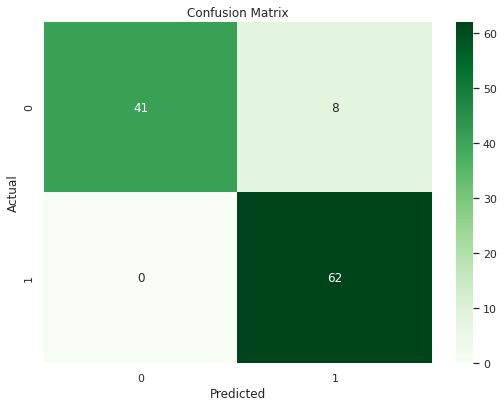

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.84      0.91        49
           1       0.89      1.00      0.94        62

    accuracy                           0.93       111
   macro avg       0.94      0.92      0.93       111
weighted avg       0.94      0.93      0.93       111



In [ ]:
evaluate_model(svc_clf)

#### Naive Bayes

Model Accuracy:
Precision on training data: 0.984
Precision on testing data: 0.968
Accuracy on test data: 0.973


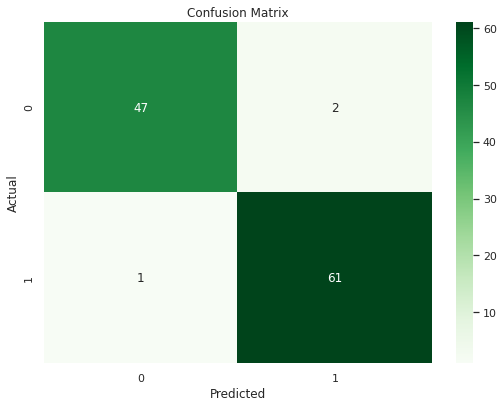

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        49
           1       0.97      0.98      0.98        62

    accuracy                           0.97       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.97      0.97      0.97       111



In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_features, train_targets)
evaluate_model(gnb)

#### KNN

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score, GridSearchCV

knn_cv = neighbors.KNeighborsClassifier()
parameter_grid = {'n_neighbors': [1,2,3,4,5,6,7,8]}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_cv, parameter_grid, cv=5, scoring='precision')

#fit model to data
knn_gscv.fit(train_features, train_targets)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=0)

In [ ]:
# top performance
print("Top Performance: ", knn_gscv.best_params_)
# score for top_performance
print("Top CV score: ", knn_gscv.best_score_)

Top Performance:  {'n_neighbors': 2}
Top CV score:  0.9536747181964573


In [ ]:
n_neighbors = 2
knn = neighbors.KNeighborsClassifier(n_neighbors,)
knn.fit(train_features, train_targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.968
Accuracy on test data: 0.964


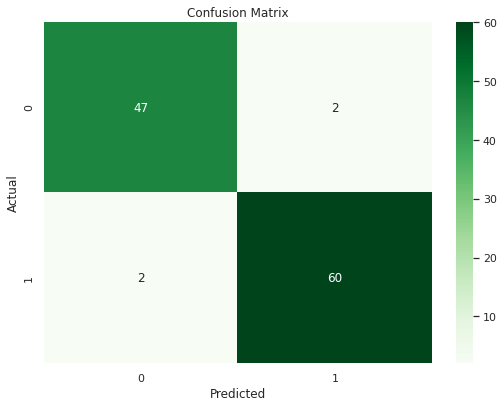

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        49
           1       0.97      0.97      0.97        62

    accuracy                           0.96       111
   macro avg       0.96      0.96      0.96       111
weighted avg       0.96      0.96      0.96       111



In [ ]:
evaluate_model(knn)

#### Decision Tree

In [ ]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc.fit(train_features, train_targets)
test_predict = dtc.predict(test_features)

In [ ]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
np.random.seed(25)
random_states = np.random.choice(range(1,50), size = 10, replace=False)
ccp_alpha = [2**i for i in range(-10,0)]

random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state' : random_states,
               'ccp_alpha': ccp_alpha}

random_grid

{'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'random_state': array([44, 15, 41, 34, 48,  8, 33, 20, 39, 36])}

In [ ]:
# base model
dtc = tree.DecisionTreeClassifier()

dtc_random = RandomizedSearchCV(estimator = dtc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [ ]:
dtc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [ ]:
 dtc_random.best_params_


{'ccp_alpha': 0.001953125,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'random_state': 15}

In [ ]:
 dtc_random.best_score_

0.9826086956521738

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.938
Accuracy on test data: 0.946


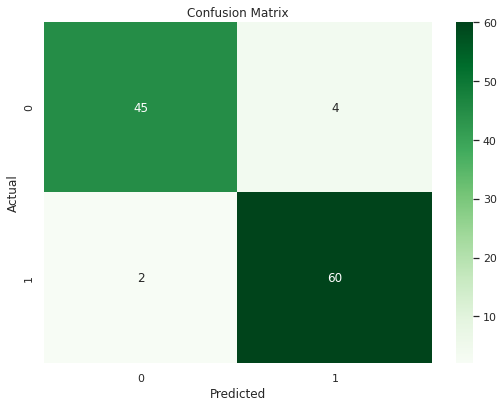

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.94      0.97      0.95        62

    accuracy                           0.95       111
   macro avg       0.95      0.94      0.94       111
weighted avg       0.95      0.95      0.95       111



In [ ]:
base_model_dtc = tree.DecisionTreeClassifier()
base_model_dtc.fit(train_features, train_targets)

evaluate_model(base_model_dtc)


Model Accuracy:
Precision on training data: 0.992
Precision on testing data: 0.968
Accuracy on test data: 0.973


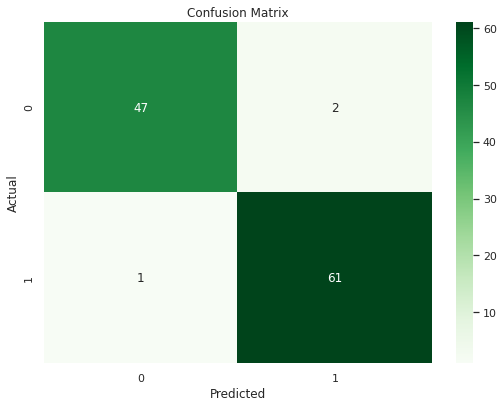

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        49
           1       0.97      0.98      0.98        62

    accuracy                           0.97       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.97      0.97      0.97       111



In [ ]:
best_random_dtc = dtc_random.best_estimator_

evaluate_model(best_random_dtc)


#### Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
ccp_alpha = [2**i for i in range(-10,0)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

random_grid

{'bootstrap': [True, False],
 'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [ ]:
rfc = RandomForestClassifier()

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [ ]:
rfc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rfc_random.best_params_


{'bootstrap': True,
 'ccp_alpha': 0.001953125,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.968
Accuracy on test data: 0.973


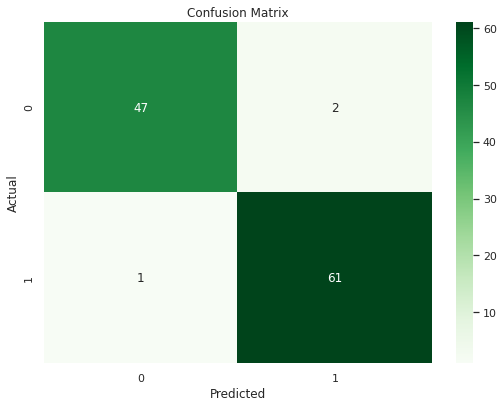

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        49
           1       0.97      0.98      0.98        62

    accuracy                           0.97       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.97      0.97      0.97       111



In [ ]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                    oob_score = True)
base_model.fit(train_features, train_targets)

evaluate_model(base_model)


Model Accuracy:
Precision on training data: 0.992
Precision on testing data: 0.968
Accuracy on test data: 0.973


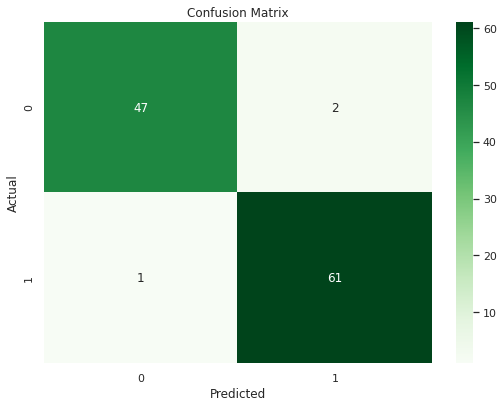

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        49
           1       0.97      0.98      0.98        62

    accuracy                           0.97       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.97      0.97      0.97       111



In [ ]:
best_random = rfc_random.best_estimator_

evaluate_model(best_random)


### Prediction for the new stars

In [ ]:
# descriptive stats
all_stars_filtered.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_2264_center
count,8.579000e+03,8.579000e+03,8.579000e+03,8579.0,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8579.000000,8.579000e+03,8579.0,8579.000000,8578.000000,8578.000000,8579.000000,8579.000000,8579.000000,...,8.509000e+03,8509.000000,8509.000000,8509.000000,8509.000000,8579.000000,8509.000000,8509.000000,8509.000000,252.000000,252.000000,8579.000000,252.000000,252.000000,252.000000,8579.000000,8579.000000,8579.000000,8579.000000,5532.000000,5532.000000,5532.000000,5532.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,3745.0,3745.000000,3745.000000,3745.000000,3745.000000,3745.000000,3745.000000,8579.000000,8579.000000,8579.000000,8579.000000
mean,1.635721e+18,3.331316e+18,8.479703e+08,2015.5,100.236390,0.108237,9.907012,0.106975,1.155187,0.122550,14.716511,-0.376963,0.211569,-4.556334,0.190420,-0.209000,0.069057,-0.169460,0.249161,-0.374252,0.124210,-0.307511,0.234861,0.106621,-0.179364,135.200256,6.876559,134.461243,0.739014,1.771706,206.625275,0.195624,3.408693e+00,31.0,24.662529,1.438085,0.026729,-0.071898,15.435715,10.279869,...,4.397564e+04,139.708509,316.086426,15.331463,1.388009,0.061313,1.694861,0.786005,0.908858,23.474527,2.520333,0.132883,5399.206543,3.529762,-0.123016,202.922436,2.196662,100.357188,-13.164344,100068.329176,4678.585938,4494.377930,4974.218262,1.139476,0.914213,1.409614,0.568361,0.452673,0.706694,200111.0,2.246582,1.997486,2.426258,5.030362,4.261920,5.798788,0.535940,25.692004,46.262289,0.535924
std,0.000000e+00,9.398968e+15,4.921639e+08,0.0,0.432805,0.104879,0.377514,0.104457,1.129556,0.114920,20.387236,7.081321,0.203751,9.249399,0.189441,0.190219,0.181845,0.207869,0.186936,0.168432,0.209363,0.190159,0.127329,0.127410,0.198076,20.309737,29.435626,20.229673,1.286199,6.286332,802.995544,0.360834,3.433497e+01,0.0,63.952747,0.115873,0.025364,0.099818,2.228059,0.790258,...,3.605760e+05,2424.768353,270.129578,1.659450,0.201796,0.269225,0.583656,0.350197,0.268177,32.087679,2.955447,0.815343,738.766907,0.651467,0.406307,0.384696,0.420125,0.436912,0.378515,360.577984,819.371277,794.171326,829.126160,0.855076,0.804812,0.903723,0.430668,0.402456,0.459122,0.0,3.225264,2.891364,3.496866,20.121920,16.989460,23.390783,0.192852,51.392309,86.095152,0.192841
min,1.635721e+18,3.326524e+18,2.842270e+05,2015.5,99.434450,0.018986,9.096209,0.018367,0.118147,0.020885,3.000654,-121.700273,0.037346,-191.265448,0.033250,-0.985580,-0.79685

In [ ]:
# chosing only GAIA stars close to 0.40 degree radius of the center
all_stars_filtered = all_stars_filtered.dropna(subset = feature_columns)
GAIA_target_stars = all_stars_filtered[all_stars_filtered['dist_2264_center'] <= 0.60]

In [ ]:
# removing the member stars from GAIA data
GAIA_target_stars = pd.concat([GAIA_target_stars, training_data.drop(columns=['PMemb', 'member']), 
                               training_data.drop(columns=['PMemb', 'member'])]).drop_duplicates(keep=False)

In [ ]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [ ]:
# train the model again using all the features and targets of the previous dataset
# rfc.fit(features, targets)

In [ ]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = best_random.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    3811
1     727
Name: member, dtype: int64

In [ ]:
# estimate the membership probability of the stars
GAIA_target_stars['PMemb'] = best_random.predict_proba(new_features)[:,1]
sum(GAIA_target_stars['PMemb'] >= 0.5)

727

In [ ]:
potentialMember = GAIA_target_stars[GAIA_target_stars['member'] == 1]
len(potentialMember)

727

In [ ]:
potentialMember.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_2264_center,member,PMemb
count,7.270000e+02,7.270000e+02,7.270000e+02,727.0,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.0,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,...,722.000000,722.000000,722.000000,727.000000,722.000000,722.000000,722.000000,6.000000,6.000000,727.000000,6.000000,6.000000,6.000000,727.000000,727.000000,727.000000,727.000000,368.000000,368.000000,368.000000,368.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,337.0,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,727.000000,727.000000,727.000000,727.000000,727.0,727.000000
mean,1.635721e+18,3.327086e+18,8.544234e+08,2015.5,100.211863,0.121950,9.725249,0.118261,1.353655,0.137060,15.690372,-2.112412,0.236776,-3.733409,0.206633,-0.139943,0.009904,-0.227841,0.270804,-0.344434,0.156157,-0.358553,0.258392,0.102481,-0.124735,139.552957,7.221458,138.837689,0.715268,3.435021,247.891418,0.339949,4.641295,31.0,17.387539,1.347632,0.032129,-0.036430,15.995873,10.393398,...,151.597305,15.453999,1.558496,0.049519,2.173472,1.043327,1.130145,9.876116,6.941494,0.039890,6291.666504,3.833333,-0.250000,203.073412,2.092120,100.346079,-13.347893,100251.375000,4450.001465,4185.493164,4864.601074,1.757151,1.474763,2.009151,0.884708,0.738255,1.014525,200111.0,1.383338,1.166645,1.523736,1.504059,1.390262,1.617856,0.337680,13.843115,28.570229,0.337693,1.0,0.880180
std,0.000000e+00,2.818934e+15,4.961969e+08,0.0,0.194207,0.080817,0.256165,0.078220,0.133757,0.090117,11.749115,0.589209,0.157112,0.387919,0.139488,0.177975,0.155545,0.173277,0.150565,0.146557,0.169409,0.146524,0.107242,0.110097,0.172089,18.964143,30.666862,18.836795,1.188826,6.414721,856.799561,0.332951,35.082398,0.0,52.067089,0.132110,0.021310,0.091686,2.094525,0.734330,...,181.680283,1.700023,0.281720,0.241144,0.670811,0.421490,0.321444,15.735090,4.362333,0.454308,458.711975,0.516398,0.612372,0.254601,0.193695,0.199468,0.254111,662.390531,1288.880493,1173.924438,1317.747559,1.004008,0.954657,1.030131,0.510019,0.481633,0.528674,0.0,0.646774,0.583035,0.657656,8.215836,7.589597,8.850020,0.133280,10.962669,20.490512,0.133286,0.0,0.141723
min,1.635721e+18,3.326589e+18,8.195537e+06,2015.5,99.637923,0.020872,9.304159,0.019971,1.054937,0.021649,3.038932,-5.348746,0.039281,-4.840374,0.035394,-0.917392,-0.668835,-0.872752,-0.927026,-0.858939,-0.934734,-0.896394,-0.350125,-0.646195,-0.966570,86.000000,0.000000,85.000000,0.000000,-6.599565,48.506165,0.000000,0.00

In [ ]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
count,1.850000e+02,1.850000e+02,1.850000e+02,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,180.000000,180.000000,180.000000,185.000000,180.000000,180.000000,180.000000,3.000000,3.000000,185.000000,3.000000,3.000000,3.0,185.000000,185.000000,185.000000,185.000000,144.000000,144.000000,144.000000,144.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.0
mean,1.635721e+18,3.326784e+18,8.285892e+08,2015.5,100.214039,0.072382,9.878222,0.071669,1.351449,0.081936,21.650196,-1.719405,0.141126,-3.745357,0.125302,-0.127327,-0.013217,-0.228196,0.287496,-0.384634,0.185720,-0.357903,0.201840,0.088960,-0.103946,152.875676,17.027027,151.940541,0.935135,4.139026,298.636963,0.213379,4.722191,31.0,28.285501,1.399563,0.018449,-0.035289,17.416216,10.637838,...,187.808090,14.515929,1.472430,0.129730,1.861798,0.861647,1.000150,17.663946,6.709235,0.102703,5833.333496,3.833333,0.0,202.938244,2.163860,100.336830,-13.195288,100556.638889,4531.785645,4245.857422,4903.776855,1.747458,1.442371,1.986919,0.877488,0.713944,1.003771,200111.0,1.408720,1.217725,1.548704,1.195102,1.119066,1.271138,0.081564,15.793914,38.804363,0.865946,0.081566,1.0
std,0.000000e+00,8.908293e+13,5.079494e+08,0.0,0.060929,0.039388,0.063977,0.039081,0.098816,0.044591,10.962818,0.439083,0.075826,0.300983,0.066869,0.167233,0.138062,0.134414,0.129976,0.127064,0.127836,0.117483,0.115337,0.110659,0.180214,17.322413,47.526587,17.354104,1.484012,8.059679,625.573181,0.227932,18.497970,0.0,72.251717,0.133858,0.009985,0.078989,1.951799,0.678614,...,185.221085,1.783798,0.223623,0.409709,0.685158,0.381381,0.348479,6.235787,4.756371,0.811094,288.675140,0.577350,0.0,0.058022,0.065835,0.060710,0.064826,898.928007,1413.615845,1237.766357,1462.936646,0.987902,0.909715,1.042373,0.494933,0.455351,0.527763,0.0,0.618332,0.618088,0.611171,3.740212,3.529193,3.951503,0.045111,8.759246,19.136053,0.202906,0.045111,0.0
min,1.635721e+18,3.326712e+18,5.929410e+05,2015.5,100.057096,0.023724,9.751314,0.022577,1.092609,0.026016,6.027352,-3.389699,0.045983,-5.199818,0.041781,-0.960296,-0.685270,-0.885211,-0.377267,-0.702543,-0.207624,-0.933394,-0.694126,-0.667703,-0.896725,105.000000,0.000000,101.000000,0.000000,-6.497139,53.549519,0.000000,0.000000,31.0,0.552160

#### Visualization

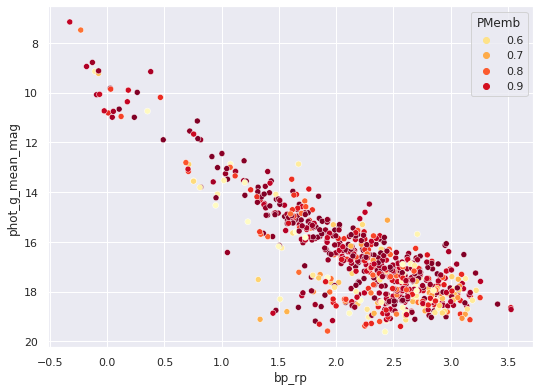

In [ ]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'bp_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
cmd.invert_yaxis()

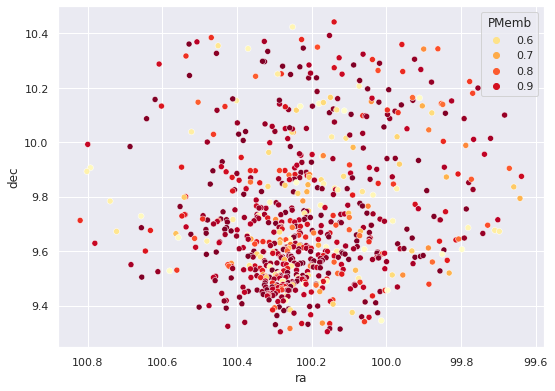

In [ ]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
skyplot.invert_xaxis()

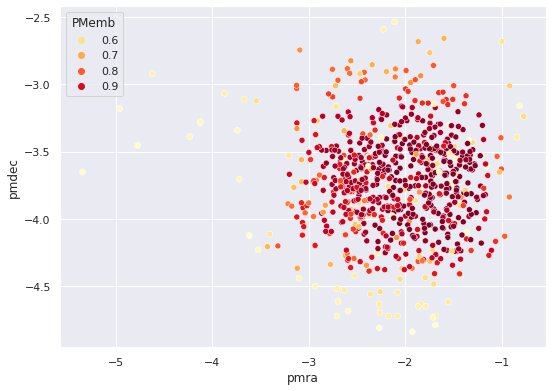

In [ ]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )


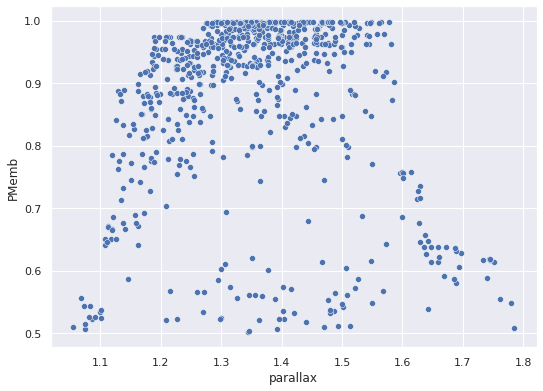

In [ ]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )

In [ ]:
# saving the files as csv
# all_stars.to_csv('gaia_2264_membership_prob.csv')

potentialMember.to_csv('NGC_2264_membership_prob.csv')


### Comparing the old and new predicted members

In [ ]:
# creating subset for the potential member in previous dataset

concatenated = pd.concat([potentialMember.assign(dataset='New_member'), member.assign(dataset='Old_member')])


In [ ]:
concatenated.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_2264_center,member,PMemb
count,9.120000e+02,9.120000e+02,9.120000e+02,912.0,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,9.120000e+02,912.0,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,...,902.000000,902.000000,902.000000,912.000000,902.000000,902.000000,902.000000,9.000000,9.000000,912.000000,9.000000,9.000000,9.000000,912.000000,912.000000,912.000000,912.000000,512.000000,512.000000,512.000000,512.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,465.0,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,912.000000,912.000000,912.000000,912.000000,912.0,912.000000
mean,1.635721e+18,3.327025e+18,8.491829e+08,2015.5,100.212304,0.111895,9.756279,0.108810,1.353208,0.125878,16.899319,-2.032690,0.217373,-3.735833,0.190135,-0.137384,0.005214,-0.227913,0.274190,-0.352589,0.162154,-0.358421,0.246920,0.099739,-0.120518,142.255482,9.210526,141.495614,0.759868,3.577830,258.185333,0.314274,4.657705e+00,31.0,19.598204,1.358166,0.029354,-0.036199,16.283991,10.442982,...,158.823349,15.266797,1.541321,0.065789,2.111275,1.007071,1.104204,12.472059,6.864074,0.052632,6138.888672,3.833333,-0.166667,203.045993,2.106672,100.344203,-13.316937,100337.230469,4473.004883,4202.472168,4875.620117,1.754930,1.467344,2.004058,0.883054,0.732687,1.012061,200111.0,1.390325,1.180706,1.530609,1.419013,1.315610,1.522414,0.285727,14.238837,30.646232,0.285738,1.0,0.877293
std,0.000000e+00,2.519732e+15,4.984302e+08,0.0,0.175521,0.076917,0.238557,0.074403,0.127400,0.085822,11.833560,0.583617,0.149378,0.371810,0.132210,0.175832,0.152373,0.166063,0.146708,0.143665,0.162214,0.141057,0.111220,0.110285,0.173869,19.389289,34.946495,19.271473,1.256557,6.781795,815.160461,0.318482,3.240292e+01,0.0,56.868755,0.134032,0.020306,0.089216,2.142930,0.729672,...,182.862946,1.756580,0.273185,0.285109,0.684754,0.419925,0.330926,13.402593,4.190819,0.545889,452.615845,0.500000,0.500000,0.235151,0.177785,0.180183,0.236808,748.415619,1324.254517,1191.312988,1358.804810,0.997586,0.942129,1.030047,0.505233,0.474593,0.527002,0.0,0.638510,0.592657,0.644640,7.261359,6.718298,7.811171,0.158701,10.577677,20.628004,0.158708,0.0,0.156061
min,1.635721e+18,3.326589e+18,5.929410e+05,2015.5,99.637923,0.020872,9.304159,0.019971,1.054937,0.021649,3.038932,-5.348746,0.039281,-5.199818,0.035394,-0.960296,-0.685270,-0.885211,-0.927026,-0.858939,-0.934734,-0.933394,-0.694126,-0.667703,-0.966570,86.000000,0.000000,85.000000,0.000000,-6.599565,48.506165,0.0

In [ ]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
count,1.850000e+02,1.850000e+02,1.850000e+02,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,180.000000,180.000000,180.000000,185.000000,180.000000,180.000000,180.000000,3.000000,3.000000,185.000000,3.000000,3.000000,3.0,185.000000,185.000000,185.000000,185.000000,144.000000,144.000000,144.000000,144.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.0
mean,1.635721e+18,3.326784e+18,8.285892e+08,2015.5,100.214039,0.072382,9.878222,0.071669,1.351449,0.081936,21.650196,-1.719405,0.141126,-3.745357,0.125302,-0.127327,-0.013217,-0.228196,0.287496,-0.384634,0.185720,-0.357903,0.201840,0.088960,-0.103946,152.875676,17.027027,151.940541,0.935135,4.139026,298.636963,0.213379,4.722191,31.0,28.285501,1.399563,0.018449,-0.035289,17.416216,10.637838,...,187.808090,14.515929,1.472430,0.129730,1.861798,0.861647,1.000150,17.663946,6.709235,0.102703,5833.333496,3.833333,0.0,202.938244,2.163860,100.336830,-13.195288,100556.638889,4531.785645,4245.857422,4903.776855,1.747458,1.442371,1.986919,0.877488,0.713944,1.003771,200111.0,1.408720,1.217725,1.548704,1.195102,1.119066,1.271138,0.081564,15.793914,38.804363,0.865946,0.081566,1.0
std,0.000000e+00,8.908293e+13,5.079494e+08,0.0,0.060929,0.039388,0.063977,0.039081,0.098816,0.044591,10.962818,0.439083,0.075826,0.300983,0.066869,0.167233,0.138062,0.134414,0.129976,0.127064,0.127836,0.117483,0.115337,0.110659,0.180214,17.322413,47.526587,17.354104,1.484012,8.059679,625.573181,0.227932,18.497970,0.0,72.251717,0.133858,0.009985,0.078989,1.951799,0.678614,...,185.221085,1.783798,0.223623,0.409709,0.685158,0.381381,0.348479,6.235787,4.756371,0.811094,288.675140,0.577350,0.0,0.058022,0.065835,0.060710,0.064826,898.928007,1413.615845,1237.766357,1462.936646,0.987902,0.909715,1.042373,0.494933,0.455351,0.527763,0.0,0.618332,0.618088,0.611171,3.740212,3.529193,3.951503,0.045111,8.759246,19.136053,0.202906,0.045111,0.0
min,1.635721e+18,3.326712e+18,5.929410e+05,2015.5,100.057096,0.023724,9.751314,0.022577,1.092609,0.026016,6.027352,-3.389699,0.045983,-5.199818,0.041781,-0.960296,-0.685270,-0.885211,-0.377267,-0.702543,-0.207624,-0.933394,-0.694126,-0.667703,-0.896725,105.000000,0.000000,101.000000,0.000000,-6.497139,53.549519,0.000000,0.000000,31.0,0.552160

In [ ]:
concatenated.dataset.value_counts()

New_member    727
Old_member    185
Name: dataset, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

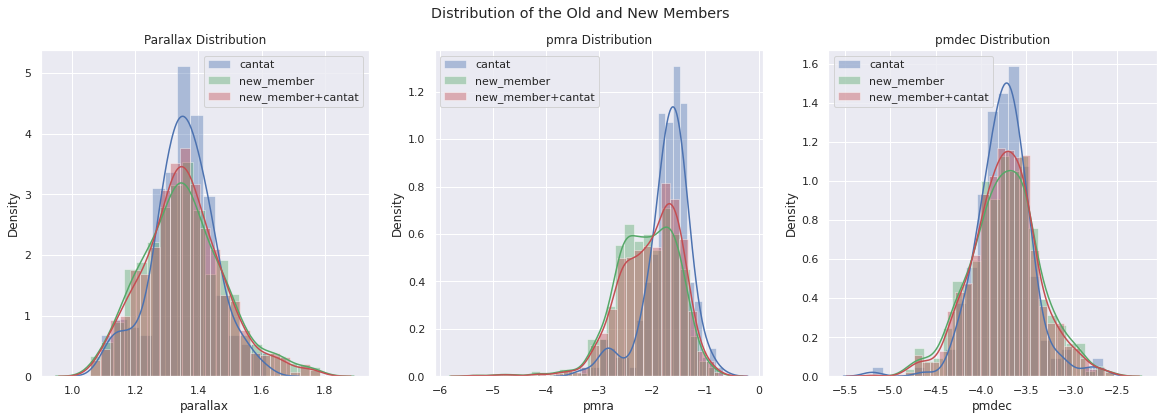

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Distribution of the Old and New Members')


sns.distplot(member['parallax'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[0])
sns.distplot(potentialMember['parallax'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[0])
sns.distplot(concatenated['parallax'], color = 'r', ax=axes[0], kde=True,
             label = 'new_member+cantat')
axes[0].set_title('Parallax Distribution')
axes[0].legend()

sns.distplot(member['pmra'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[1])
sns.distplot(potentialMember['pmra'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[1])
sns.distplot(concatenated['pmra'], color = 'r', ax=axes[1], kde=True,
             label = 'new_member+cantat')
axes[1].set_title('pmra Distribution')
axes[1].legend()

sns.distplot(member['pmdec'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[2])
sns.distplot(potentialMember['pmdec'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[2])
sns.distplot(concatenated['pmdec'], color = 'r', ax=axes[2], kde=True,
             label = 'new_member+cantat')
axes[2].set_title('pmdec Distribution')
axes[2].legend()

plt.show()


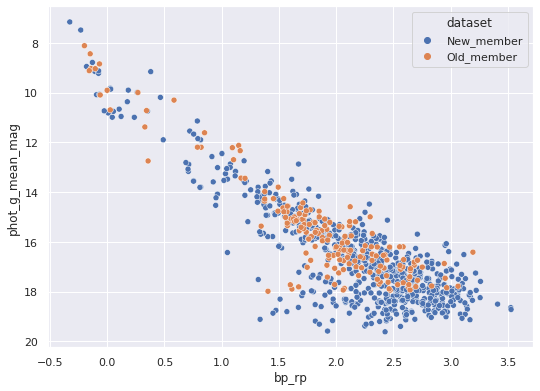

In [ ]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset')
cmd.invert_yaxis()

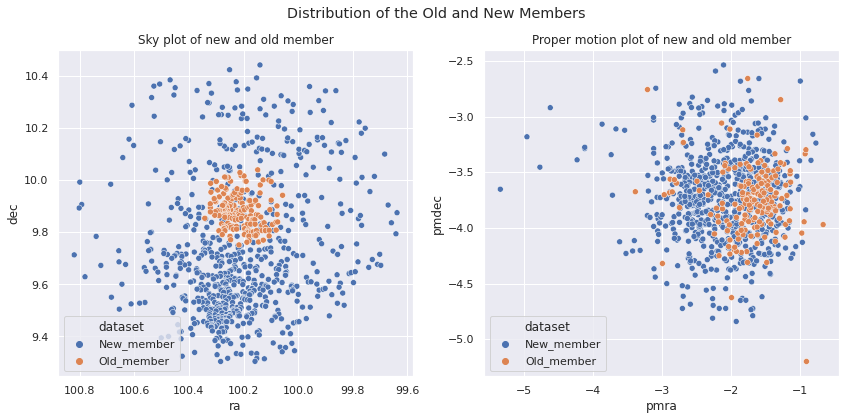

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Distribution of the Old and New Members')

skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                hue='dataset', ax=axes[0])
skyplot.invert_xaxis()
axes[0].set_title('Sky plot of new and old member')

# proper motion plot
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', ax=axes[1])
axes[1].set_title('Proper motion plot of new and old member')

plt.show()

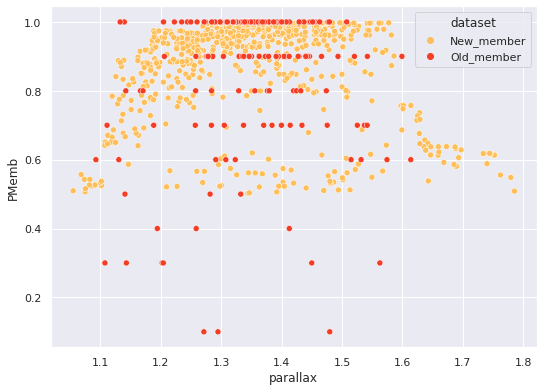

In [ ]:
# parallax vs PMemb plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  hue = 'dataset',
                      palette='YlOrRd', data = concatenated )

In [ ]:
# pd_prof.ProfileReport(potentialMember)

In [ ]:
#files.download('NGC_2264_cantat.csv')

#files.download('NGC_2264_membership_prob.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


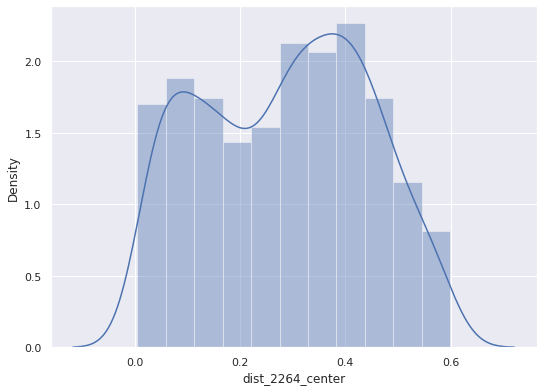

In [ ]:
sns.distplot(concatenated['dist_2264_center'])

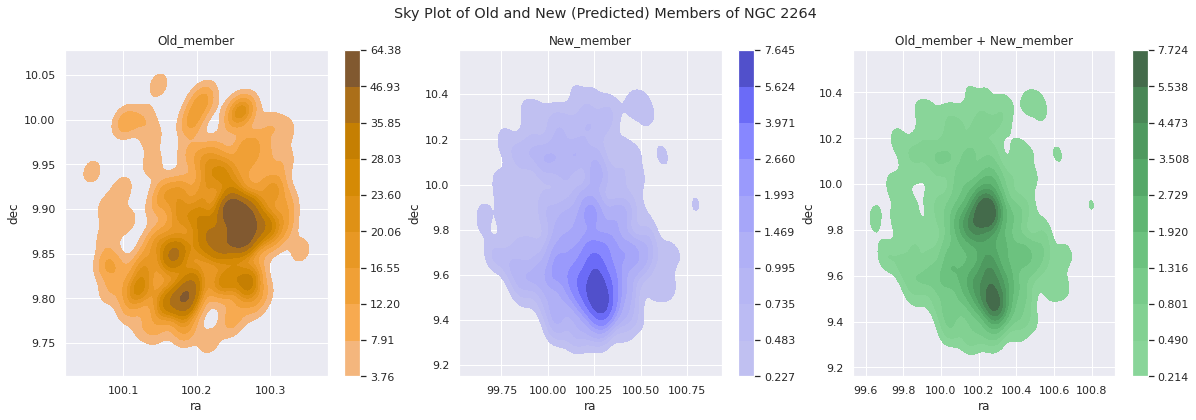

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Sky Plot of Old and New (Predicted) Members of NGC 2264')

sns.kdeplot(x='ra', y='dec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='ra', y='dec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='ra', y='dec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

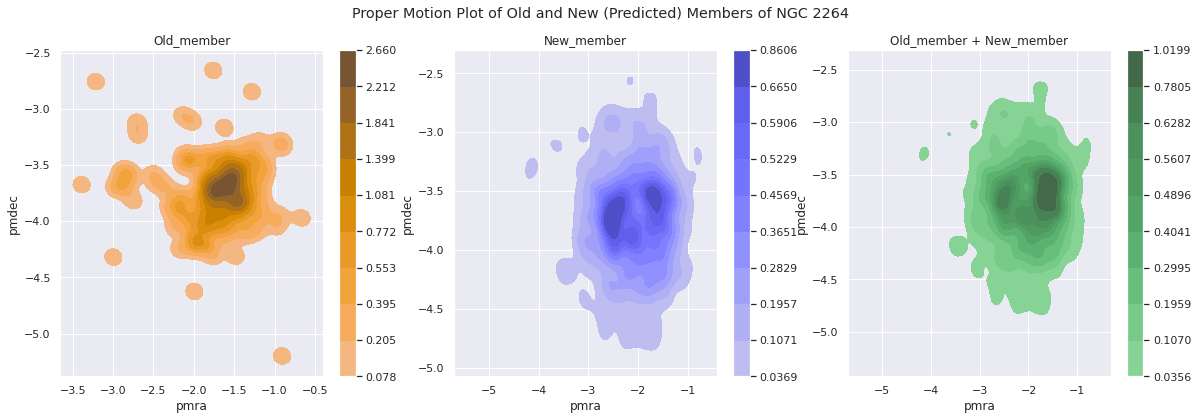

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Proper Motion Plot of Old and New (Predicted) Members of NGC 2264')

sns.kdeplot(x='pmra', y='pmdec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='pmra', y='pmdec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='pmra', y='pmdec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()